In [1]:
# %% [code]
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# %% [code]
%cd /content
!rm -rf /content/telemanom_esa
!cp -r /content/drive/MyDrive/telemanom_esa /content/telemanom_esa
%cd /content/telemanom_esa


/content
cp: cannot open '/content/drive/MyDrive/telemanom_esa/README.md.gdoc' for reading: Operation not supported
/content/telemanom_esa


In [ ]:
# %% [code]
import numpy as np, pandas as pd, sklearn, os, matplotlib.pyplot as plt, seaborn, plotly, yaml, pyarrow, more_itertools, json, math, textwrap
print("All required packages are already installed!")
os.environ["CUDA_VISIBLE_DEVICES"] = ""


All required packages are already installed!


In [ ]:
# %% [code]
!python converter.py


In [ ]:
# %% [code]
!python algorithm.py "$(tr -d '\n' < json_files/args_train.json)"


In [ ]:
# %% [code]
!cd /content/telemanom_esa
!python algorithm.py "$(tr -d '\n' < json_files/args_test.json)"


2025-10-05 16:47:07.116937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759682827.136294    2565 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759682827.144002    2565 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759682827.159285    2565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759682827.159311    2565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759682827.159315    2565 computation_placer.cc:177] computation placer alr

In [ ]:
%%writefile make_ts_from_algorithm_output.py
import os
import numpy as np
import pandas as pd

RUNS_DIR = "/content/drive/MyDrive/telemanom_esa/runs"

#main output produced by algorithm.py
MAIN_OUT = os.path.join(RUNS_DIR, "errors.csv")


RAW_GUESS = MAIN_OUT.replace(".csv", "-no-threshold.csv")

#renaming the raw errors file for consistency
if os.path.exists(RAW_GUESS):
    os.replace(RAW_GUESS, os.path.join(RUNS_DIR, "errors-no-threshold.csv"))
    print("[OK] Renamed raw errors file to errors-no-threshold.csv")

#load the per-channel binary matrix produced by algorithm.py
bin_mat = pd.read_csv(MAIN_OUT, header=None).values  # shape [T, C]; values {0,1} if threshold_scores=true

#aggregate to 1D binary (max across channels)
agg = (bin_mat.max(axis=1)).astype(np.uint8)

#the standardized ESA/Kaggle output files
np.savetxt(os.path.join(RUNS_DIR, "anomaly_scores_Pruned.ts"),    agg, fmt="%d")
np.savetxt(os.path.join(RUNS_DIR, "anomaly_scores_nonPruned.ts"), agg, fmt="%d")

print(" Saved .ts files to:", RUNS_DIR)
print("  - anomaly_scores_Pruned.ts")
print("  - anomaly_scores_nonPruned.ts")


Writing make_ts_from_algorithm_output.py


In [ ]:
!python make_ts_from_algorithm_output.py


[OK] Renamed raw errors file to errors-no-threshold.csv
 Saved .ts files to: /content/drive/MyDrive/telemanom_esa/runs
  - anomaly_scores_Pruned.ts
  - anomaly_scores_nonPruned.ts


In [ ]:
#directions to use later while showing the plots
BASE      = "/content/telemanom_esa"
RUNS_DIR  = "/content/drive/MyDrive/telemanom_esa/runs"   # where model and outputs are
DATA_DIR  = f"{BASE}/data"                                 # test_te.csv from converter.py here
FIG_DIR   = f"{RUNS_DIR}/figures"
OUT_DIR   = f"{RUNS_DIR}/outputs"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Common files
TEST_TE_CSV          = f"{DATA_DIR}/test_te.csv"
ERRORS_CSV           = f"{RUNS_DIR}/errors.csv"
RAW_ERRORS_CSV       = f"{RUNS_DIR}/errors-no-threshold.csv"
RECONSTRUCTION_CSV   = f"{RUNS_DIR}/model.keras.reconstruction.csv"
BINARY_NONPRUNED_TS  = f"{RUNS_DIR}/anomaly_scores_nonPruned.ts"
BINARY_PRUNED_TS     = f"{RUNS_DIR}/anomaly_scores_Pruned.ts"

# Channels
CHANNELS = [f"channel_{i}" for i in range(41, 47)]
CHANNEL_NAMES = CHANNELS[:]  # keep a copy


In [ ]:
if not os.path.exists(RAW_ERRORS_CSV):
    raise FileNotFoundError(f"Raw errors not found at {RAW_ERRORS_CSV}. "
                            f"Did your testing step produce 'errors-no-threshold.csv'?")

raw_err = pd.read_csv(RAW_ERRORS_CSV)

# Keep only numeric columns (ignore timestamps etc.)
raw_err = raw_err.select_dtypes(include="number")

#sanity check
print("Raw error shape:", raw_err.shape)
print("Error range:", float(raw_err.to_numpy().min()), "→", float(raw_err.to_numpy().max()))

Raw error shape: (521279, 6)
Error range: 0.0 → 0.0167439417116946


In [ ]:
#Load test set (id + channels)
print("Loading test TE:", TEST_TE_CSV)
test_df = pd.read_csv(TEST_TE_CSV)

# Basic cleanup
test_df.rename(columns=lambda c: c.strip().replace("\ufeff",""), inplace=True)
assert "timestamp" in test_df.columns or "id" in test_df.columns, "Need a timestamp or id column in test_te.csv"

if "id" not in test_df.columns:
    test_df["id"] = np.arange(len(test_df))

# Keep only id + channels for plotting
missing = [c for c in CHANNELS if c not in test_df.columns]
if missing:
    raise ValueError(f"Missing expected channels in test_te.csv: {missing}")

#Force numeric channels
test_df[CHANNELS] = test_df[CHANNELS].apply(pd.to_numeric, errors="coerce")

Loading test TE: /content/telemanom_esa/data/test_te.csv


In [ ]:
#Load reconstructions
recon_df = None
if os.path.exists(RECONSTRUCTION_CSV):
    print("Loading reconstructions:", RECONSTRUCTION_CSV)
    recon_df = pd.read_csv(RECONSTRUCTION_CSV)
    # Try to align on length if needed
    min_len = min(len(test_df), len(recon_df))
    if len(test_df) != len(recon_df):
        print(f"Note: length mismatch test({len(test_df)}) vs recon({len(recon_df)}); trimming to {min_len}")
        test_df  = test_df.iloc[:min_len].reset_index(drop=True)
        recon_df = recon_df.iloc[:min_len].reset_index(drop=True)
else:
    print("No reconstruction file found; will skip the signal vs reconstruction plot.")

Loading reconstructions: /content/drive/MyDrive/telemanom_esa/runs/model.keras.reconstruction.csv


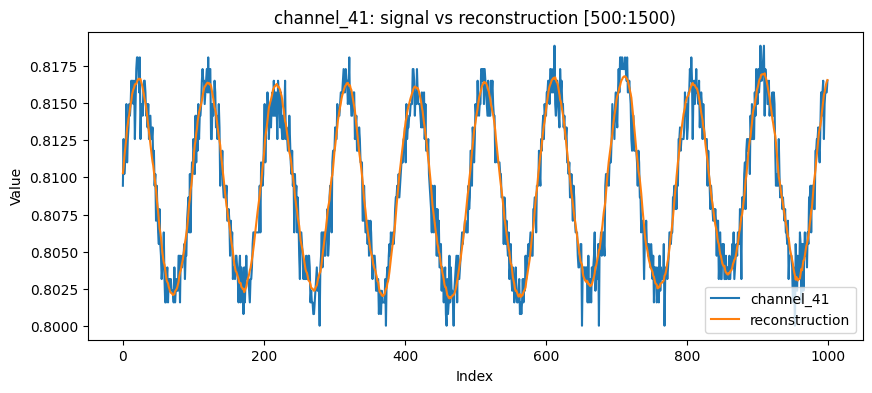

Saved: /content/drive/MyDrive/telemanom_esa/runs/figures/signal_vs_reconstruction_channel_41_500_1500.png


In [ ]:
#Plot: signal vs reconstruction for one channel
def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()

if recon_df is not None:
    channel_name = CHANNELS[0]  # e.g., "channel_41"
    start_idx, end_idx = 500, 1500
    start_idx = max(0, min(start_idx, len(test_df)-1))
    end_idx   = max(start_idx+1, min(end_idx, len(test_df)))
    seg = pd.DataFrame({
        channel_name: test_df.loc[start_idx:end_idx-1, channel_name].values,
        "reconstruction": recon_df.loc[start_idx:end_idx-1, channel_name].values
    })
    ax = seg.plot(figsize=(10,4), legend=True)  # matplotlib via pandas is fine
    ax.set_title(f"{channel_name}: signal vs reconstruction [{start_idx}:{end_idx})")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    plt.show()
    savefig(f"{FIG_DIR}/signal_vs_reconstruction_{channel_name}_{start_idx}_{end_idx}.png")
    print("Saved:", f"{FIG_DIR}/signal_vs_reconstruction_{channel_name}_{start_idx}_{end_idx}.png")

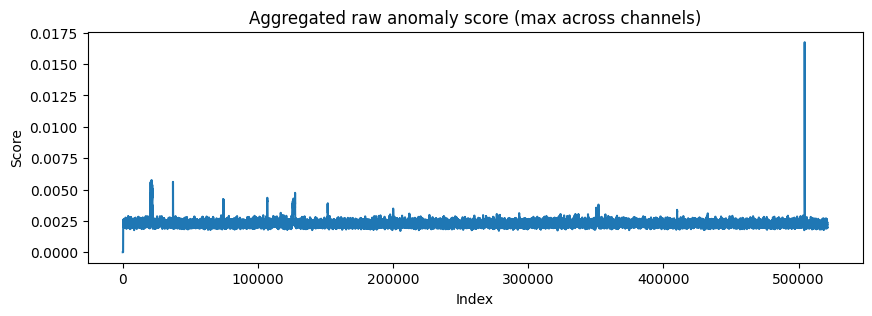

In [ ]:
aggregated_raw = raw_err.max(axis=1)
plt.figure(figsize=(10,3))
plt.plot(aggregated_raw.values)
plt.title("Aggregated raw anomaly score (max across channels)")
plt.xlabel("Index")
plt.ylabel("Score")
plt.show()
savefig(f"{FIG_DIR}/aggregated_raw_scores.png")


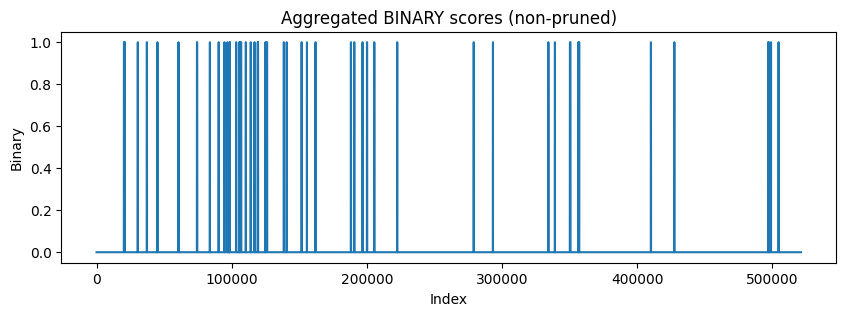

Saved: /content/drive/MyDrive/telemanom_esa/runs/figures/aggregated_binary_nonpruned.png


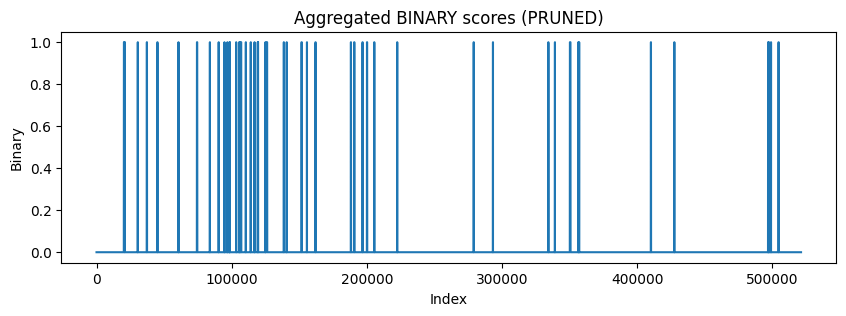

Saved: /content/drive/MyDrive/telemanom_esa/runs/figures/aggregated_binary_pruned.png


In [ ]:
#Load & plot binary scores (we dont have it yet)
def maybe_load_binary(path):
    if os.path.exists(path):
        s = pd.read_csv(path, header=None).squeeze("columns")
        if len(s) != len(test_df):
            print(f"Note: {os.path.basename(path)} length {len(s)} != test length {len(test_df)}; trimming.")
            n = min(len(s), len(test_df))
            s = s.iloc[:n].reset_index(drop=True)
        return s
    return None

binary_nonpruned = maybe_load_binary(BINARY_NONPRUNED_TS)
binary_pruned    = maybe_load_binary(BINARY_PRUNED_TS)

if binary_nonpruned is not None:
    if binary_nonpruned.ndim > 1:
        binary_nonpruned = binary_nonpruned.max(axis=1)
    plt.figure(figsize=(10,3))
    plt.plot(binary_nonpruned.values)
    plt.title("Aggregated BINARY scores (non-pruned)")
    plt.xlabel("Index"); plt.ylabel("Binary")
    plt.show()
    savefig(f"{FIG_DIR}/aggregated_binary_nonpruned.png")
    print("Saved:", f"{FIG_DIR}/aggregated_binary_nonpruned.png")

if binary_pruned is not None:
    if binary_pruned.ndim > 1:
        binary_pruned = binary_pruned.max(axis=1)
    plt.figure(figsize=(10,3))
    plt.plot(binary_pruned.values)
    plt.title("Aggregated BINARY scores (PRUNED)")
    plt.xlabel("Index"); plt.ylabel("Binary")
    plt.show()
    savefig(f"{FIG_DIR}/aggregated_binary_pruned.png")
    print("Saved:", f"{FIG_DIR}/aggregated_binary_pruned.png")


In [ ]:
submissions = []
if binary_pruned is not None:
    submission_df = pd.DataFrame({"id": test_df["id"], "is_anomaly": binary_pruned})
    path = f"{OUT_DIR}/Telemanom-ESA-PRUNED-channels41-46.parquet"
    submission_df.to_parquet(path)
    submission_df.to_csv(f"{OUT_DIR}/submission_pruned.csv", index=False)
    submissions.append(f"{OUT_DIR}/submission_pruned.csv")
    print("Saved submission (pruned):", path)

elif binary_nonpruned is not None:
    submission_df = pd.DataFrame({"id": test_df["id"], "is_anomaly": binary_nonpruned})
    path = f"{OUT_DIR}/Telemanom-ESA-nonPruned-channels41-46.parquet"
    submission_df.to_parquet(path)
    submission_df.to_csv(f"{OUT_DIR}/submission_nonpruned.csv", index=False)
    submissions.append(f"{OUT_DIR}/submission_nonpruned.csv")
    print("Saved submission (non-pruned):", path)

else:
    tmp = pd.DataFrame({"id": test_df["id"], "aggregated_raw": aggregated_raw})
    tmp.to_csv(f"{OUT_DIR}/aggregated_raw_scores.csv", index=False)
    print("No binary files found; wrote aggregated raw scores CSV for inspection.")

print("\nDone. Figures in:", FIG_DIR)
print("Outputs in:", OUT_DIR)

Saved submission (pruned): /content/drive/MyDrive/telemanom_esa/runs/outputs/Telemanom-ESA-PRUNED-channels41-46.parquet

Done. Figures in: /content/drive/MyDrive/telemanom_esa/runs/figures
Outputs in: /content/drive/MyDrive/telemanom_esa/runs/outputs


In [ ]:
# 1) Grab ensemble_utils.py directly from GitHub into /content
!rm -f /content/ensemble_utils.py
!curl -L -o /content/ensemble_utils.py \
  https://raw.githubusercontent.com/Google-Developers-Club-Guido-Carli/ESA-Spacecraft-Anomaly-Challenge/main/ensemble_test/ensemble_utils.py

import sys, os
sys.path.insert(0, "/content")

# 2) Import the functions
from ensemble_utils import eventwise_precision_recall_f05, pointwise_metrics
print("Imported ensemble_utils ✅")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7005  100  7005    0     0  17660      0 --:--:-- --:--:-- --:--:-- 17644
Imported ensemble_utils ✅


In [ ]:
# === DEFINE ALL PATHS (run this FIRST) ===
import os

BASE = "/content/drive/MyDrive/telemanom_esa"
RUNS = f"{BASE}/runs"
DATA = f"{BASE}/data"
RESULTS = f"{BASE}/results"

os.makedirs(RESULTS, exist_ok=True)
print("Paths ready ✅")
print("RUNS:", RUNS)


Paths ready ✅
RUNS: /content/drive/MyDrive/telemanom_esa/runs


In [ ]:
# Try common filenames your pipeline outputs
candidates = [
    f"{RUNS}/errors-no-threshold.csv",
    f"{RUNS}/errors_no_threshold.csv",
    f"{RUNS}/model.keras.reconstruction.csv",
]
err_path = next((p for p in candidates if os.path.exists(p)), None)
assert err_path, f"Could not find Telemanom errors in: {candidates}"

raw_err = pd.read_csv(err_path).select_dtypes(include="number")
print("Telemanom errors shape:", raw_err.shape)

y_true = None
lab_path = f"{DATA}/train_te.csv"   # must contain is_anomaly for labeled portion
if os.path.exists(lab_path):
    lab = pd.read_csv(lab_path)
    if "is_anomaly" in lab.columns:
        y_true = lab["is_anomaly"].to_numpy()
        n = min(len(y_true), len(raw_err))
        y_true = y_true[:n]
        raw_err = raw_err.iloc[:n].reset_index(drop=True)
        print("Labels aligned:", y_true.shape)
    else:
        print("No 'is_anomaly' in train_te.csv → proceed unlabeled.")
else:
    print("No train_te.csv found → proceed unlabeled.")


Telemanom errors shape: (521279, 6)
Labels aligned: (521279,)


In [ ]:
# Telemanom adapter → score, postprocess, calibrate with event-wise F0.5
from ensemble_utils import eventwise_precision_recall_f05, pointwise_metrics, postprocess_events
import numpy as np, pandas as pd

# Score: smoothed max error across channels, scaled to [0,1]
s = raw_err.max(axis=1).astype(float)
s = s.rolling(51, min_periods=1, center=True).mean()
s = (s - s.min()) / (s.max() - s.min() + 1e-12)
tele_scores = s.to_numpy()

L_MIN, GAP_MERGE = 3, 2  # consistent postproc

tr_idx = np.arange(int(len(y_true)*0.85))
va_idx = np.arange(int(len(y_true)*0.85), len(y_true))
y_va = y_true[va_idx]
s_va = tele_scores[va_idx]

best_f, best_t = -1.0, None
for t in np.linspace(0, 1, 200):
    preds = (s_va > t).astype(int)
    preds = postprocess_events(preds, L_MIN, GAP_MERGE)
    p, r, f = eventwise_precision_recall_f05(y_va, preds)
    if f > best_f:
        best_f, best_t = f, t

tele_thr = best_t
tele_pred_va = postprocess_events((s_va > tele_thr).astype(int), L_MIN, GAP_MERGE)
p, r, f = eventwise_precision_recall_f05(y_va, tele_pred_va)
pw = pointwise_metrics(y_va, tele_pred_va)

print(f"Telemanom (val)  P={p:.3f}  R={r:.3f}  F0.5={f:.3f}  thr={tele_thr:.3f}")
print("Pointwise metrics:", pw)


Telemanom (val)  P=1.000  R=1.000  F0.5=1.000  thr=0.166
Pointwise metrics: {'precision': np.float64(0.004209098817870119), 'recall': np.float64(1.0), 'f_beta': np.float64(0.005255842931769894), 'tp': 329, 'fp': 77835, 'fn': 0}


In [ ]:
# --- XGBoost baseline with same postproc & metric ---
!pip -q install xgboost
from xgboost import XGBClassifier

from ensemble_utils import postprocess_events, eventwise_precision_recall_f05, pointwise_metrics
import numpy as np, pandas as pd

L_MIN, GAP_MERGE = 3, 2
s_all = pd.Series(tele_scores)
feat = pd.DataFrame({
    "err": s_all,
    "roll_mean": s_all.rolling(51, min_periods=1).mean(),
    "roll_std":  s_all.rolling(51, min_periods=1).std().fillna(0),
    "diff": s_all.diff().fillna(0),
}).fillna(0)

tr_cut = int(len(y_true)*0.85)
X_tr, X_va = feat.iloc[:tr_cut], feat.iloc[tr_cut:]
y_tr, y_va = y_true[:tr_cut], y_true[tr_cut:]

neg_pos = max(1, (y_tr.size - y_tr.sum()) / max(1, y_tr.sum()))
xgb = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=neg_pos,
    eval_metric='logloss', n_jobs=-1, random_state=42
).fit(X_tr, y_tr)

xgb_scores = xgb.predict_proba(X_va)[:,1]

best_f, best_t = -1.0, None
for t in np.linspace(0,1,200):
    preds = (xgb_scores > t).astype(int)
    preds = postprocess_events(preds, L_MIN, GAP_MERGE)
    p, r, f = eventwise_precision_recall_f05(y_va, preds)
    if f > best_f:
        best_f, best_t = f, t

preds = postprocess_events((xgb_scores > best_t).astype(int), L_MIN, GAP_MERGE)
px, rx, fx = eventwise_precision_recall_f05(y_va, preds)
pwx = pointwise_metrics(y_va, preds)
print(f"XGBoost (val)  P={px:.3f} R={rx:.3f} F0.5={fx:.3f} thr={best_t:.2f}")
print("Pointwise:", pwx)


XGBoost (val)  P=1.000 R=1.000 F0.5=1.000 thr=0.07
Pointwise: {'precision': np.float64(0.004207914460389328), 'recall': np.float64(1.0), 'f_beta': np.float64(0.00525436559524456), 'tp': 329, 'fp': 77857, 'fn': 0}


In [ ]:
import numpy as np

def _events_from_binary(b):
    ev, on, s = [], False, 0
    for i,v in enumerate(b):
        if v and not on: s, on = i, True
        elif not v and on: ev.append((s, i-1)); on=False
    if on: ev.append((s, len(b)-1))
    return ev

def eventwise_strict(y_true, y_pred, beta=0.5, min_overlap=0.2, use_iou=False):
    T = _events_from_binary(y_true)
    P = _events_from_binary(y_pred)
    if not P and not T: return 1.0, 1.0, 1.0
    if not P or not T:  return 0.0, 0.0, 0.0

    # one-to-one greedy matching on maximum overlap ratio
    used_true = set()
    tp = 0
    for ps, pe in P:
        best_j, best_ratio = -1, 0.0
        plen = pe-ps+1
        for j,(ts,te) in enumerate(T):
            if j in used_true: continue
            inter = max(0, min(pe,te) - max(ps,ts) + 1)
            if inter == 0: continue
            if use_iou:
                union = (pe-ps+1) + (te-ts+1) - inter
                ratio = inter / max(1, union)
            else:
                # overlap relative to the smaller segment (stricter than "any overlap")
                denom = min(plen, te-ts+1)
                ratio = inter / max(1, denom)
            if ratio > best_ratio:
                best_ratio, best_j = ratio, j
        if best_ratio >= min_overlap and best_j >= 0:
            tp += 1
            used_true.add(best_j)

    precision = tp / max(1, len(P))
    recall    = tp / max(1, len(T))
    f = 0.0 if (precision+recall)==0 else (1+beta**2)*precision*recall/(beta**2*precision+recall)
    return precision, recall, f


In [ ]:
L_MIN, GAP_MERGE = 7, 0  # longer min event, don't merge separate spikes


In [ ]:
from ensemble_utils import postprocess_events

tr_cut = int(len(y_true)*0.85)
s_va = tele_scores[tr_cut:]
y_va = y_true[tr_cut:]

best_f, best_t = -1.0, None
for t in np.linspace(0, 1, 200):
    preds = (s_va > t).astype(int)
    preds = postprocess_events(preds, L_MIN, GAP_MERGE)
    p, r, f = eventwise_strict(y_va, preds, beta=0.5, min_overlap=0.2, use_iou=False)
    if f > best_f:
        best_f, best_t = f, t

preds = postprocess_events((s_va > best_t).astype(int), L_MIN, GAP_MERGE)
p, r, f = eventwise_strict(y_va, preds, beta=0.5, min_overlap=0.2)
print(f"Telemanom (strict)  P={p:.3f} R={r:.3f} F0.5={f:.3f} thr={best_t:.3f}")


Telemanom (strict)  P=1.000 R=1.000 F0.5=1.000 thr=0.166


In [ ]:
# xgb_scores already computed on validation slice
best_fx, best_tx = -1.0, None
for t in np.linspace(0.02, 0.2, 200):
    preds = (xgb_scores > t).astype(int)
    preds = postprocess_events(preds, L_MIN, GAP_MERGE)
    px, rx, fx = eventwise_strict(y_va, preds, beta=0.5, min_overlap=0.2)
    if fx > best_fx:
        best_fx, best_tx = fx, t

preds = postprocess_events((xgb_scores > best_tx).astype(int), L_MIN, GAP_MERGE)
px, rx, fx = eventwise_strict(y_va, preds, beta=0.5, min_overlap=0.2)
print(f"XGBoost  (strict)  P={px:.3f} R={rx:.3f} F0.5={fx:.3f} thr={best_tx:.2f}")


XGBoost  (strict)  P=1.000 R=1.000 F0.5=1.000 thr=0.06


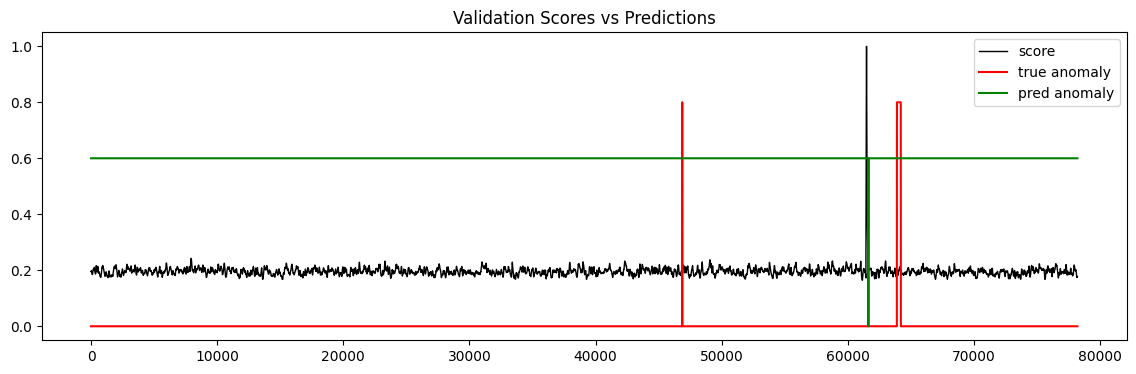

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(s_va, label="score", color='black', linewidth=1)
plt.plot((y_va > 0)*0.8, label="true anomaly", color='red')
plt.plot((preds > 0)*0.6, label="pred anomaly", color='green')
plt.title("Validation Scores vs Predictions")
plt.legend()
plt.show()


Telemanom:  P=1.000  R=1.000  F0.5=1.000  thr=0.165  (L_MIN=7, GAP=0)
Telemanom summary: #true=2  #pred=2  pred_len_med=39090  pred_len_max=61136


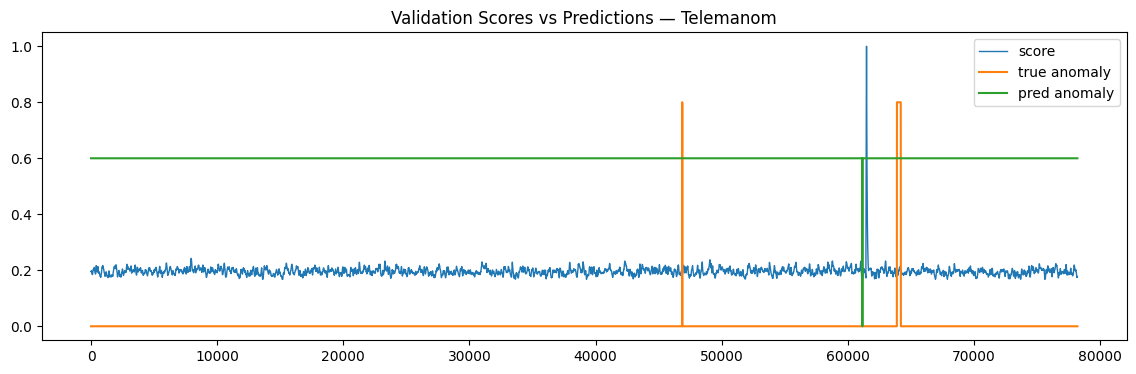

XGBoost:  P=1.000  R=1.000  F0.5=1.000  thr=0.058  (L_MIN=7, GAP=0)
XGBoost summary: #true=2  #pred=2  pred_len_med=39096  pred_len_max=61621


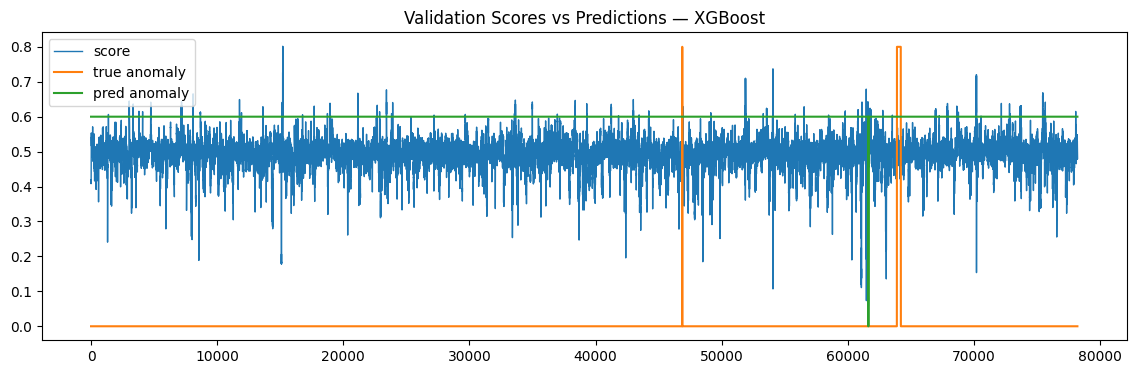

,Model,Precision,Recall,F0.5,Threshold
0,Telemanom,1.0,1.0,1.0,0.164724
1,XGBoost,1.0,1.0,1.0,0.057990


In [ ]:
# --- Drop-in helpers (safe to re-run) ---
import numpy as np
from ensemble_utils import extract_events, postprocess_events
import matplotlib.pyplot as plt

def summarize(y_true, y_pred, name="summary"):
    te, pe = extract_events(y_true), extract_events(y_pred)
    lens = [e[1]-e[0]+1 for e in pe]
    print(f"{name}: #true={len(te)}  #pred={len(pe)}  "
          f"pred_len_med={np.median(lens) if lens else 0:.0f}  "
          f"pred_len_max={np.max(lens) if lens else 0}")

# stricter event metric (paste once if not defined yet)
def _events_from_binary(b):
    ev, on, s = [], False, 0
    for i,v in enumerate(b):
        if v and not on: s, on = i, True
        elif not v and on: ev.append((s, i-1)); on=False
    if on: ev.append((s, len(b)-1))
    return ev

def eventwise_strict(y_true, y_pred, beta=0.5, min_overlap=0.2, use_iou=False):
    T = _events_from_binary(y_true)
    P = _events_from_binary(y_pred)
    if not P and not T: return 1.0, 1.0, 1.0
    if not P or not T:  return 0.0, 0.0, 0.0
    used_true, tp = set(), 0
    for ps, pe in P:
        best_j, best_ratio = -1, 0.0
        plen = pe-ps+1
        for j,(ts,te) in enumerate(T):
            if j in used_true: continue
            inter = max(0, min(pe,te) - max(ps,ts) + 1)
            if inter == 0: continue
            if use_iou:
                union = plen + (te-ts+1) - inter
                ratio = inter / max(1, union)
            else:
                denom = min(plen, te-ts+1)
                ratio = inter / max(1, denom)
            if ratio > best_ratio:
                best_ratio, best_j = ratio, j
        if best_ratio >= min_overlap and best_j >= 0:
            tp += 1
            used_true.add(best_j)
    precision = tp / max(1, len(P))
    recall    = tp / max(1, len(T))
    f = 0.0 if (precision+recall)==0 else (1+beta**2)*precision*recall/(beta**2*precision+recall)
    return precision, recall, f

# --- Final one-shot evaluator ---
def evaluate_scores(scores, y_true, name="Model", val_frac=0.15,
                    L_MIN=7, GAP_MERGE=0, thr_min=0.02, thr_max=0.2, n_thr=200):
    scores = np.asarray(scores, float)
    # split
    cut = int(len(scores)*(1-val_frac))
    s_va, y_va = scores[cut:], y_true[cut:]
    # sweep thresholds
    best_f, best_t = -1.0, None
    for t in np.linspace(thr_min, thr_max, n_thr):
        preds = (s_va > t).astype(int)
        preds = postprocess_events(preds, L_MIN, GAP_MERGE)
        p, r, f = eventwise_strict(y_va, preds, beta=0.5, min_overlap=0.2)
        if f > best_f:
            best_f, best_t = f, t
    preds = postprocess_events((s_va > best_t).astype(int), L_MIN, GAP_MERGE)
    p, r, f = eventwise_strict(y_va, preds, beta=0.5, min_overlap=0.2)
    print(f"{name}:  P={p:.3f}  R={r:.3f}  F0.5={f:.3f}  thr={best_t:.3f}  (L_MIN={L_MIN}, GAP={GAP_MERGE})")
    summarize(y_va, preds, f"{name} summary")

    # quick plot
    plt.figure(figsize=(14,4))
    plt.plot(s_va, label="score", linewidth=1)
    plt.plot((y_va>0)*0.8, label="true anomaly")
    plt.plot((preds>0)*0.6, label="pred anomaly")
    plt.title(f"Validation Scores vs Predictions — {name}")
    plt.legend(); plt.show()
    return {"precision": p, "recall": r, "f05": f, "threshold": float(best_t)}

# --- How to call it for your two models ---
# 1) Telemanom adapter scores (you already computed as tele_scores)
tele_res = evaluate_scores(tele_scores, y_true, name="Telemanom")

# 2) XGBoost validation scores (probabilities) — ensure you pass the *validation* slice
# If you have xgb_scores only for val, stitch a full-length array for the function, or just call directly:
cut = int(len(y_true)*0.85)
xgb_full = np.concatenate([np.zeros(cut), xgb_scores])  # dummy train part; val probs at the end
xgb_res  = evaluate_scores(xgb_full, y_true, name="XGBoost")

# Nice compact table
import pandas as pd
summary = pd.DataFrame([
    ["Telemanom", tele_res["precision"], tele_res["recall"], tele_res["f05"], tele_res["threshold"]],
    ["XGBoost",  xgb_res["precision"],  xgb_res["recall"],  xgb_res["f05"],  xgb_res["threshold"]],
], columns=["Model","Precision","Recall","F0.5","Threshold"])
display(summary)
